In [1]:
# Install latest development of transformers from hugggingface
!pip install git+https://github.com/huggingface/transformers
!pip install attrdict
!pip install torchviz

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-lfq2h4gv
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-lfq2h4gv
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 67 kB 2.9 MB/s 
     |████████████████████████████████| 895 kB 11.4 MB/s 
     |████████████████████████████████| 6.5 MB 35.0 MB/s 
     |████████████████████████████████| 596 kB 43.8 MB/s 
  Created wheel for transformers: filename=transformers-4.18.0.dev0-py3-none-any.whl size=3926086 sha256=01fa7818461bcc0e8cb8d8f91cb2b2f95133609d78abf4a2164b210ea7e90f10
  Stored in directory: /tmp/pip-ephem-wheel-cache-7de_x4j2/wheels/35/2e/a7/d819e3310040329f0f47e57c9e3e7a7338aa5e74c49acfe522
Successfully built transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uni

# Bert GoEmotions in Pytorch

In [2]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


## Imports

In [3]:
import os
import random
import logging
import matplotlib.pyplot as plt
import datetime
import statistics

import torch
import numpy as np

from sklearn.metrics import precision_recall_fscore_support, accuracy_score

import torch.nn as nn
from transformers import DistilBertPreTrainedModel, DistilBertModel

from typing import Union, Optional

from transformers.pipelines import ArgumentHandler
from transformers import (
    Pipeline,
    PreTrainedTokenizer,
    ModelCard
)

import copy
import json

from torch.utils.data import TensorDataset

import glob

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm, trange
from attrdict import AttrDict

from transformers import (
    DistilBertConfig,
    DistilBertTokenizer,
    AdamW,
    get_linear_schedule_with_warmup
)

## Utils

Set some utils function used in the scripts:

- _init_logger_(): initialize the logger  
- _set_seed(args)_: set the seed for the random weights generator  
- _compute_metrics(labels, pred)_: compute different metrics between the true output _labels_ and the predicted output _pred_

In [4]:
def init_logger():
    logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s - %(message)s',
                        datefmt='%m%d%Y %H:%M:%S',
                        level=logging.INFO)
    
    
def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if not args.no_cuda and torch.cuda.is_available():
        torch.cuda.manual_seed_all(args.seed)
        
"""Compute different metrics in the evaluation part"""
def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    results = dict()
    
    results["accuracy"] = accuracy_score(labels, preds)
    results["macro_precision"], results["macro_recall"], results["macro_f1"], _ = precision_recall_fscore_support(labels, preds, average="macro")
    results["micro_precision"], results["micro_recall"], results["micro_f1"], _ = precision_recall_fscore_support(labels, preds, average="micro")
    results["weighted_precision"], results["weighted_recall"], results["weighted_f1"], _ = precision_recall_fscore_support(labels, preds, average="weighted")
    
    return results

## Model creation

Build the baseline model based on Bert. Since it is a MultiLabel classification problem, we need to tweak the standard Bert Model.

We add to the baseline Bert a Dropout layer and a Linear layer.

The batch sample is passed through the model, and the predicted logits are collected returning a tuple containing:

```
(logits, hidden_states, attention_mask)
```

The loss function instead compute the required binary crossentropy with logits loss between the predicted output and the true labels, returning the loss

In [5]:
# Max Pooling - Take the max value over time for every dimension. 
def max_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    token_embeddings[input_mask_expanded == 0] = -1e9  # Set padding tokens to large negative value
    return torch.max(token_embeddings, 1)[0]


class DistilBertForMultiLabelClassification(DistilBertModel):
    """Extends the base BertPreTrainedModel to use Bert for multilabel classification"""
    
    
    """
        @param config: configuration file with all the required parameters to instantiate the BertModel
    """
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        # Model structure
        self.distilbert = DistilBertModel(config)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(config.hidden_size, self.config.num_labels)
        self.loss_fct = nn.BCEWithLogitsLoss()

        self.init_weights()
        
        
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None
    ):
        
        """ Outputs of the bert model: https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertModel
            The forward method of the base BertModel return a tuple of 3 values
            
                - outputs[0] = last_hidden_state: Sequence of hidden-states at the output of the last layer of the model
                - outputs[1] = pooler_output: last layer output, i.e. returns the classificatio token after passing through a linear layer and a tanh activation function
                - outputs[2] = hidden_states: another tuple containing the output of the embeddings together with the output of each hidden state """
        outputs = self.distilbert(
            input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds
        )

        # Apply max_pooling last_hidden_state output
        pooled_output = max_pooling(outputs, attention_mask)
        
        # Pass through dropout layer
        pooled_output = self.dropout(pooled_output)
        # Classify the instances with a linear layer
        logits = self.classifier(pooled_output)

        # Build the outputs to return: concatenate in a tuple the predicted logits and the hidden states
        outputs = (logits,) + outputs[1:]  # add hidden states and attention if they are here

        if labels is not None:
            # Compute binary crossentropy loss between the predicted logits and the actual labels
            loss = self.loss_fct(logits, labels)
            # Concatenate in a tuple the loss, logits, hidden states and attentions
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

## MultiLabel Pipeline

In [6]:
class MultiLabelPipeline(Pipeline):
    """Implements pipeline operation"""
    
    def __init__(
        self,
        model: Union["PreTrainedModel", "TFPreTrainedModel"],
        tokenizer: PreTrainedTokenizer,
        modelcard: Optional[ModelCard] = None,
        framework: Optional[str] = None,
        task: str = "",
        args_parser: ArgumentHandler = None,
        device: int = -1,
        binary_output: bool = False,
        threshold: float = 0.3
    ):
        
        super().__init__(
            model = model,
            tokenizer = tokenizer,
            modelcard = modelcard,
            framework = framework,
            args_parser = args_parser,
            device = device,
            binary_output = binary_output,
            task = task
        )
        
        self.threshold = threshold
        
        
    def __call__(self, *args, **kwargs):
        
        outputs = super().__call__(*args, **kwargs)
        scores = 1 / (1 + np.exp(-outputs)) # Apply Sigmoid function
        results = []
        for item in scores:
            labels = []
            scores = []
            for idx, s in enumerate(item):
                if s > self.threshold:
                    labels.append(self.model.config.id2label[idx])
                    scores.append(s)
            results.append({"labels": labels, "scores": scores})
        return results
        

## DataLoader

In [7]:
logger = logging.getLogger(__name__)


class InputExample(object):
    """A single training/test example for simple sequence classification"""
    
    """ Initialize a single input example, passing the guid (mode: [train, test, dev] and an integer for the sentence), 
        together with the text_a (the actual text), text_b (always None) and the label (class vector of that sentence) """
    def __init__(self, guid, text_a, text_b, label):
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label
        
    """ Utility funtions """   
    def __repr__(self):
        return str(self.to_json_string())
    
    def to_dict(self):
        """Serializes instance to Python dict"""
        output = copy.deepcopy(self.__dict__)
        return output
    
    def to_json_string(self):
        """Serializes this instance to a JSON string"""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"
    
    
class InputFeatures(object):
    """A single set of features of data"""
    
    """ Build the sentence using the Bert language, i.e. passing through
            - input_ids: integer representation of the different tokens
            - attention_mask: set to 1 the non padding tokens
            - token_type_ids: used for question/answering sentence, i.e. set to 1 the tokens that starts the answer to the question
            - label: class vector of this sentence """
    def __init__(self, input_ids, attention_mask, token_type_ids, label):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.token_type_ids = token_type_ids
        self.label = label
        
    def __repr__(self):
        return str(self.to_json_string())
    
    def to_dict(self):
        """Serialize this instance to a Python dict"""
        output = copy.deepcopy(self.__dict__)
        return output
    
    def to_json_string(self):
        """Serializes this instance to a JSON string"""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"
    

def convert_examples_to_features(
    args, 
    examples,
    tokenizer,
    max_length
):
    
    # Instantiate GoEmotionsProcessor
    processor = GoEmotionsProcessor(args)
    # Get the length of labels: 27+1 for original, less for ekman and group
    label_list_len = len(processor.get_labels())
    
    """ One hot conversion, i.e. an array of len(num_labels) containing 1 in the position corresponding to the true class """
    def convert_to_one_hot_label(label):
        one_hot_label = [0] * label_list_len
        for l in label:
            one_hot_label[l] = 1
            
        return one_hot_label
    
    # Create one hot encoding of list of labels
    labels = [convert_to_one_hot_label(example.label) for example in examples]
    
    """ 
        https://huggingface.co/docs/transformers/v4.16.2/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase
        Create a BatchEncoding understandable for the model, i.e. generate the """
    batch_encoding = tokenizer.batch_encode_plus(
        [(example.text_a, example.text_b) for example in examples], max_length=max_length, pad_to_max_length=True
    )
  
    # Create features
    features = []
    for i in range(len(examples)):
        inputs = {k: batch_encoding[k][i] for k in batch_encoding}

        inputs["token_type_ids"] = [0]*len(inputs["attention_mask"])#tokenizer.create_token_type_ids_from_sequences(inputs["input_ids"])

        # print(inputs)
        
        feature = InputFeatures(**inputs, label=labels[i])
        features.append(feature)
        
    for i, example in enumerate(examples[:10]):
        logger.info("*** Example ***")
        logger.info("guid {}".format(example.guid))
        logger.info("sentence: {}".format(example.text_a))
        logger.info("tokens: {}".format(" ".join([str(x) for x in tokenizer.tokenize(example.text_a)])))
        logger.info("input_ids: {}".format(" ".join([str(x) for x in features[i].input_ids])))
        logger.info("attention_mask: {}".format(" ".join([str(x) for x in features[i].attention_mask])))
        logger.info("token_type_ids: {}".format(" ".join([str(x) for x in features[i].token_type_ids])))
        logger.info("label: {}".format(" ".join([str(x) for x in features[i].label])))
        
    return features



class GoEmotionsProcessor(object):
    """Processor for the GoEmotions dataset"""
    
    def __init__(self, args):
        self.args = args
        
    """ Read labels names from file """
    def get_labels(self):
        labels = []
        with open(os.path.join(self.args.data_dir, self.args.label_file), "r", encoding="utf-8") as f:
            for line in f:
                labels.append(line.rstrip())
        return labels
        
    """ Read the file containing the sentences, the guid, the true labels """
    @classmethod
    def _read_file(cls, input_file):
        """Reads a tab separated value file"""
        with open(input_file, "r", encoding="utf-8") as f:
            return f.readlines()
        
    def _create_examples(self, lines, set_type):
        """ Create examples for the train, dev and test set. Simply look at https://drive.google.com/file/d/15yYrch1AE7JSM4QYTq8QBqmU3N9XkWTI/view?usp=sharing
            to understand how InputExample are generated """
        examples = []
        for (i, line) in enumerate(lines):
            # Create the guid, e.g. train-0, train-1 ecc..
            guid = "%s-%s" % (set_type, i)
            # Remove whitespaces around line
            line = line.strip()
            # Split by tab
            items = line.split("\t")
            # Take text
            text_a = items[0]
            # Create list from the set of labels, separated by comma
            label = list(map(int, items[1].split(",")))
            if i % 5000 == 0:
                logger.info(line)
            # Create InputExample and append to the list of samples
            examples.append(InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples
    
    """ Create examples for training, testing and validation file """
    def get_examples(self, mode):
        """Args: mode: train, dev, test"""
        file_to_read = None
        if mode == 'train':
            file_to_read = self.args.train_file
        elif mode == 'dev':
            file_to_read = self.args.dev_file
        elif mode == 'test':
            file_to_read = self.args.test_file
            
        logger.info("Looking at {}".format(os.path.join(self.args.data_dir, file_to_read)))
        # Call create examples on the lines returned by read_file
        return self._create_examples(self._read_file(os.path.join(self.args.data_dir, file_to_read)), mode)
    
    
""" Utility functions to save samples for next execution or generate them on the fly """
def load_and_cache_examples(args, tokenizer, mode):
    
    # Instantiate the GoEmotionsProcessor
    processor = GoEmotionsProcessor(args)
    # Load data feature from cache or dataset file
    cached_features_file = os.path.join(
        args.data_dir,
        "cached_{}_{}_{}_{}".format(
            str(args.task),
            list(filter(None, args.model_name_or_path.split("/"))).pop(),
            str(args.max_seq_len),
            mode
        )
    )
    
    # if features already exists torch.load the batch encoding
    if os.path.exists(cached_features_file):
        logger.info("Loading features from cached file %s", cached_features_file)
        features = torch.load(cached_features_file)
    # else create examples on the fly with the processor
    else:
        logger.info("Creating features from dataset file %s", args.data_dir)
        
        if mode == "train":
            examples = processor.get_examples("train")
        elif mode == "dev":
            examples = processor.get_examples("dev")
        elif mode == "test":
            examples = processor.get_examples("test")
        else:
            raise ValueError("For mode, only train, dev, test is available")
            
        # Convert the InputExample to InputFeature
        features = convert_examples_to_features(
            args, examples, tokenizer, max_length=args.max_seq_len
        )
        logger.info("Saving features into cached file %s", cached_features_file)
        
    # Convert everything to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    all_labels = torch.tensor([f.label for f in features], dtype=torch.float)

    dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)
    return dataset

## Train, Validation functions

In [8]:
# Data structure to store trainig, validation and testing results
train_history = []
train_history_epochs = []
val_history = []
val_history_epochs = []
test_history = []

In [9]:
def train(
    args,
    model,
    tokenizer,
    train_dataset,
    dev_dataset=None,
    test_dataset=None
):
    # Sample randomly from the training dataset and create the DataLoader
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args.train_batch_size)
    
    # Tweak saving of models to each training end
    args.save_steps = len(train_dataloader)
    
    print("Save steps after: {}".format(args.save_steps))
    
    # Tweak validation execution at the end of each training epoch
    args.logging_steps = len(train_dataloader)
    
    # if maximum steps are specified
    if args.max_steps > 0:
        # Set t_total
        t_total = args.max_steps
        # Modify number of training epochs e.g.: 1 // (2714 // 1) + 1 = 1
        args.num_train_epochs = args.max_steps // (len(train_dataloader) // args.gradient_accumulation_steps) + 1
    else:
        # Otherwise set t_total to e.g.: 2714 // 1 * 5 = 2714*5 = 13570
        t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs
        
    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
         'weight_decay': args.weight_decay},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    
    # Set up optimizer
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    # Set up scheduler https://huggingface.co/docs/transformers/main_classes/optimizer_schedules#transformers.SchedulerType
    # e.g. num_warmup_steps: int(2714*5*0.1) = 1357
    #      num_training_steps: 13570
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(t_total * args.warmup_proportion),
        num_training_steps=t_total
    )
    
    # Load optimizer and scheduler if they were saved
    if os.path.isfile(os.path.join(args.model_name_or_path, "optimizer.pt")) and os.path.isfile(
        os.path.join(args.model_name_or_path, "scheduler.pt")
    ):
        optimizer.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "optimizer.pt")))
        scheduler.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "scheduler.pt")))
        
    # Start training
    logger.info("***** Running Training *****")
    logger.info("  Num exampler = %d", len(train_dataset))
    logger.info("  Num epochs = %d", args.num_train_epochs)
    logger.info("  Total train batch size = %d", args.train_batch_size)
    logger.info("  Gradient accumulation steps = %d", args.gradient_accumulation_steps)
    logger.info("  Total optimization steps = %d", t_total)
    logger.info("  Logging steps = %d", args.logging_steps)
    logger.info("  Save steps = %d", args.save_steps)
    
    global_step = 0
    tr_loss = 0.0
    
    model.zero_grad()

    for epoch in range(args.num_train_epochs):
        step = 0
        support = []
        for batch in tqdm(train_dataloader, desc="Training", leave=None):
            # Set model to training
            model.train()
            batch = tuple(t.to(args.device) for t in batch)
            # Extract input elements from the batch
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "token_type_ids": batch[2],
                "labels": batch[3]
            }
            
            # Forward inputs through the models
            outputs = model(**inputs)
            
            # Take loss
            loss = outputs[0]

            # Normalize loss
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps
                
            # Call backward over the loss
            loss.backward()
            tr_loss += loss.item()
            train_history.append(loss.item())
            support.append(loss.item())
            # Always called: first condition is always true since gradient_accumulation_steps is set to 1.
            # If increase, than the model accumulate gradient for the steps specified and then make a step in the optimization
            if (step + 1) % args.gradient_accumulation_steps == 0 or (
                len(train_dataloader) <= args.gradient_accumulation_steps
                and (step + 1) == len(train_dataloader)
            ):
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
                
                # Make a step for scheduler and optimizer
                optimizer.step()
                scheduler.step()
                model.zero_grad()
                # Increase global steps
                global_step += 1
                
                # When we reach the same step of logging_steps, we perform an evaluation on the validation set
                # Tweak logging_steps to perform validation at the end of each batch, like for args.save_steps
                if args.logging_steps > 0 and global_step % args.logging_steps == 0:
                    if args.evaluate_test_during_training:
                        evaluate(args, model, test_dataset, "test", global_step)
                    else:
                        evaluate(args, model, dev_dataset, "dev", global_step)
                        
                # Save checkpoint of the model when global_step reaches save_steps
                if args.save_steps > 0 and global_step % args.save_steps == 0:
                    
                    # Save checkpoint
                    output_dir = os.path.join(args.output_dir, "checkpoint-{}".format(global_step))
                    
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                        
                    model_to_save = (
                        model.module if hasattr(model, "module") else model
                    )
                    
                    model_to_save.save_pretrained(output_dir)
                    tokenizer.save_pretrained(output_dir)
                    
                    torch.save(args, os.path.join(output_dir, "training_args.bin"))
                    logger.info("Saving model checkpoint to {}".format(output_dir))
                    
                    if args.save_optimizer:
                        torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
                        torch.save(scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))
                        logger.info("Saving optimizer and scheduler states to {}".format(output_dir))
                        
            step += 1
            
            # Stop training when maximum steps are reached
            if args.max_steps > 0 and global_step > args.max_steps:
                break
        
        train_history_epochs.append(statistics.mean(support))
        
        # Stop training when maximum steps are reached
        if args.max_steps > 0 and global_step > args.max_steps:
            break
            
    return global_step, tr_loss / global_step

## Validation/Testing

In [10]:
def evaluate(args, model, eval_dataset, mode, global_step = None):
 
    # Prepare results dict, sampler and DataLoader for the validation/testing phase
    results = {}
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size)
    
    # Validation
    if global_step != None:
        logger.info("**** Running evaluation on {} dataset ({} step) ****".format(mode, global_step))
    else:
        logger.info("**** Running evaluation on {} dataset ****".format(mode))
    logger.info("  Num examples = {}".format(len(eval_dataset)))
    logger.info("  Eval batch size = {}".format(args.eval_batch_size))
    
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    
    
    for batch in tqdm(eval_dataloader, desc="Evaluation", leave=False):
        # Set model to eval
        model.eval()
        batch = tuple(t.to(args.device) for t in batch)
        
        # Dont't consider gradient (we are in evaluation phase)
        with torch.no_grad():
            
            # Extract inputs from batch
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "token_type_ids": batch[2],
                "labels": batch[3]
            }
            
            # Pass through the model
            outputs = model(**inputs)
            # Take computed loss and predicted labels
            tmp_eval_loss, logits = outputs[:2]
            
            # Update current validation loss
            eval_loss += tmp_eval_loss.mean().item()

            if mode == "dev":
                val_history.append(tmp_eval_loss.mean().item())
            else:
                test_history.append(tmp_eval_loss.mean().item())
            
        nb_eval_steps += 1
        # If preds is none, apply sigmoid to the predicted logits and update preds and out_label_ids
        if preds is None:
            preds = 1 / (1 + np.exp(-logits.detach().cpu().numpy())) # Apply sigmoid
            out_label_ids = inputs["labels"].detach().cpu().numpy()
        # Otherwise append to the predicted array the current predicted lables and the true labels to the out_label_ids
        else:
            preds = np.append(preds, 1 / (1 + np.exp(-logits.detach().cpu().numpy())), axis = 0) # Sigmoid
            out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis = 0)
    
            
    eval_loss = eval_loss / nb_eval_steps
    results = {
        "loss": eval_loss
    }
    
    val_history_epochs.append(eval_loss)
    
    # Heuristics to bring predicted class to 1, non predicted class to 0
    preds[preds > args.threshold] = 1
    preds[preds <= args.threshold] = 0
    # Compute metrics over the current true_labels and predicted labels
    result = compute_metrics(out_label_ids, preds)
    results.update(result)
    
    # Store the results of the current validation/testing phase to a txt file, saving the mode (dev/test) and the current iteration (global_step)
    output_dir = os.path.join(args.output_dir, mode)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    output_eval_file = os.path.join(output_dir, "{}-{}.txt".format(mode, global_step) if global_step else "{}.txt".format(mode))
    
    with open(output_eval_file, "w") as f_w:
        logger.info("**** Evaluation results on {} dataset ****".format(mode))
        for key in sorted(results.keys()):
            logger.info(" {} = {} ".format(key, str(results[key])))
            f_w.write(" {} = {}\n".format(key, str(results[key])))
            
    return results

## Main code

In [ ]:
TAXONOMY = "group" # (ekman, group)

baseline_directory = "/content/drive/Shareddrives/HLT/"

config_filename = "{}.json".format(TAXONOMY)

with open(os.path.join("/content/drive/Shareddrives/HLT/config", config_filename)) as f:
    args = AttrDict(json.load(f))
    
logger.info("Training/Validation parameters {}".format(args))

args.model_type = "distilbert"

args.model_name_or_path = "distilbert-base-cased"

args.tokenizer_name_or_path = "distilbert-base-cased"

args.output_dir = "distilbert-base-cased-goemotions-{}".format(TAXONOMY)

args.output_dir = os.path.join(args.ckpt_dir, args.output_dir)

args.output_dir = os.path.join(baseline_directory, args.output_dir)

args.data_dir = os.path.join(baseline_directory, args.data_dir)

# Tweak train epochs
args.num_train_epochs = 5

init_logger()
set_seed(args)

# Set up processor and label list
processor = GoEmotionsProcessor(args)
label_list = processor.get_labels()

# Create configuration from pretrained model
config = DistilBertConfig.from_pretrained(
    args.model_name_or_path,
    num_labels=len(label_list),
    finetuning_task=args.task,
    id2label={str(i): label for i, label in enumerate(label_list)},
    label2id={label: i for i, label in enumerate(label_list)}
)   
    
# Create tokenizer for the sentences
tokenizer = DistilBertTokenizer.from_pretrained(
    args.tokenizer_name_or_path
)

# Create model
model = DistilBertForMultiLabelClassification.from_pretrained(
    args.model_name_or_path,
    config=config
)

# GPU or CPU
args.device = "cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu"
model.to(args.device)

# Loading dataset
train_dataset = load_and_cache_examples(args, tokenizer, mode="train") if args.train_file else None
dev_dataset = load_and_cache_examples(args, tokenizer, mode="dev") if args.dev_file else None
test_dataset = load_and_cache_examples(args, tokenizer, mode="test") if args.test_file else None

if dev_dataset is None:
    args.evaluate_test_during_training = True # Use only test dataset if no validation set is available
    
# Start training
if args.do_train:
    global_step, tr_loss = train(args, model, tokenizer, train_dataset, dev_dataset, test_dataset)
    logger.info(" global_step = {}, average loss = {}".format(global_step, tr_loss))
    
results = {}

## Evaluate the saved model at each checkpoint on the separate test set
if args.do_eval:
    checkpoints = list(
        os.path.dirname(c) for c in sorted(glob.glob(args.output_dir + "/**/" + "pytorch_model.bin", recursive=True))
    )
    
    if not args.eval_all_checkpoints: 
        checkpoints = checkpoints[-1:]
    else:
        logging.getLogger("transformers.configuration_utils").setLevel(logging.WARN)
        logging.getLogger("transformers.modeling_utils").setLevel(logging.WARN)
    logger.info("Evaluate the following checkpoints: %s", checkpoints)
    for checkpoint in checkpoints:
        global_step = checkpoint.split("-")[-1]
        model = DistilBertForMultiLabelClassification.from_pretrained(checkpoint)
        model.to(args.device)
        result = evaluate(args, model, test_dataset, mode="test", global_step=global_step)
        result = dict((k + "_{}".format(global_step), v) for k, v in result.items())
        results.update(result)
        
    output_eval_file = os.path.join(args.output_dir, "eval_results.txt")
    with open(output_eval_file, "w") as f_w: 
        for key in sorted(results.keys()):
            f_w.write("{} = {}\n".format(key, str(results[key])))

03092022 17:57:44 - INFO - __main__ - Training/Validation parameters AttrDict({'task': 'goemotions', 'data_dir': 'data/group', 'ckpt_dir': 'ckpt/group', 'output_dir': 'bert-base-cased-goemotions-group', 'train_file': 'train.tsv', 'dev_file': 'dev.tsv', 'test_file': 'test.tsv', 'label_file': 'labels.txt', 'evaluate_test_during_training': False, 'eval_all_checkpoints': True, 'save_optimizer': False, 'do_lower_case': False, 'do_train': True, 'do_eval': True, 'max_seq_len': 50, 'num_train_epochs': 10, 'weight_decay': 0.0, 'gradient_accumulation_steps': 1, 'adam_epsilon': 1e-08, 'warmup_proportion': 0.1, 'max_steps': -1, 'max_grad_norm': 1.0, 'no_cuda': False, 'model_type': 'bert', 'model_name_or_path': 'bert-base-cased', 'tokenizer_name_or_path': 'monologg/bert-base-cased-goemotions-group', 'seed': 777, 'train_batch_size': 16, 'eval_batch_size': 32, 'logging_steps': 1000, 'save_steps': 1000, 'learning_rate': 5e-05, 'threshold': 0.3})
Some weights of the model checkpoint at distilbert-base-

Save steps after: 2715


Training:   0%|          | 0/2714 [00:00<?, ?it/s]03092022 18:06:35 - INFO - __main__ - **** Running evaluation on dev dataset (2715 step) ****
03092022 18:06:35 - INFO - __main__ -   Num examples = 5426
03092022 18:06:35 - INFO - __main__ -   Eval batch size = 32

Evaluation:  99%|█████████▉| 169/170 [00:18<00:00,  9.14it/s]
                                                             03092022 18:06:54 - INFO - __main__ - **** Evaluation results on dev dataset ****
03092022 18:06:54 - INFO - __main__ -  accuracy = 0.49428676741614447 
03092022 18:06:54 - INFO - __main__ -  loss = 0.3440362063400886 
03092022 18:06:54 - INFO - __main__ -  macro_f1 = 0.6815755914053365 
03092022 18:06:54 - INFO - __main__ -  macro_precision = 0.6079429918800257 
03092022 18:06:54 - INFO - __main__ -  macro_recall = 0.7802647473941295 
03092022 18:06:54 - INFO - __main__ -  micro_f1 = 0.7087703637580898 
03092022 18:06:54 - INFO - __main__ -  micro_precision = 0.6274199920979849 
03092022 18:06:54 - INFO

## Count model parameters

In [14]:
total_params = sum(p.numel() for p in model.parameters())

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(total_params)

print(trainable_params)

130387207
130387207


Visualize model

In [ ]:
print(model)

DistilBertForMultiLabelClassification(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
    

In [ ]:
from torchviz import make_dot

# Sample randomly from the training dataset and create the DataLoader
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args.train_batch_size)

batch = next(iter(train_dataloader))

batch = tuple(t.to(args.device) for t in batch)
# Extract input elements from the batch
inputs = {
    "input_ids": batch[0],
    "attention_mask": batch[1],
    "token_type_ids": batch[2],
    "labels": batch[3]
}

# Forward inputs through the models
outputs = model(**inputs)

make_dot(outputs, params=dict(model.named_parameters())).render("rnn_torchviz", format="png")

## Plotting utilities

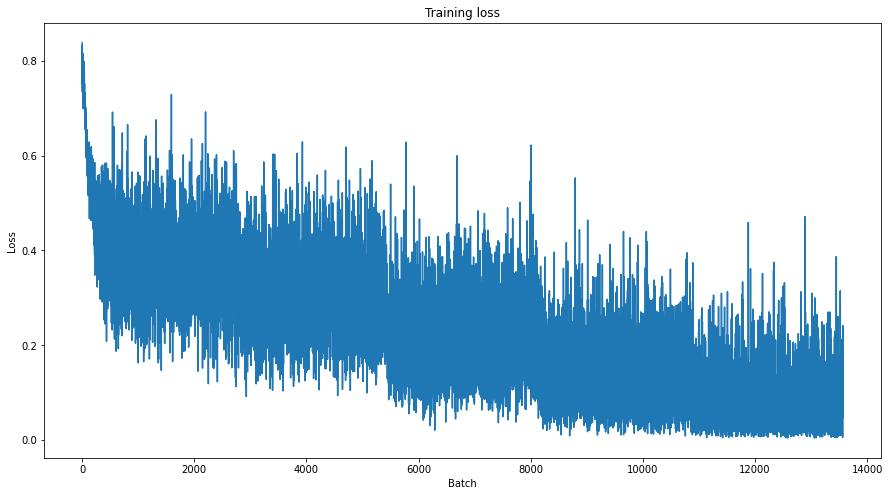

In [ ]:
# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_history)
plt.show()

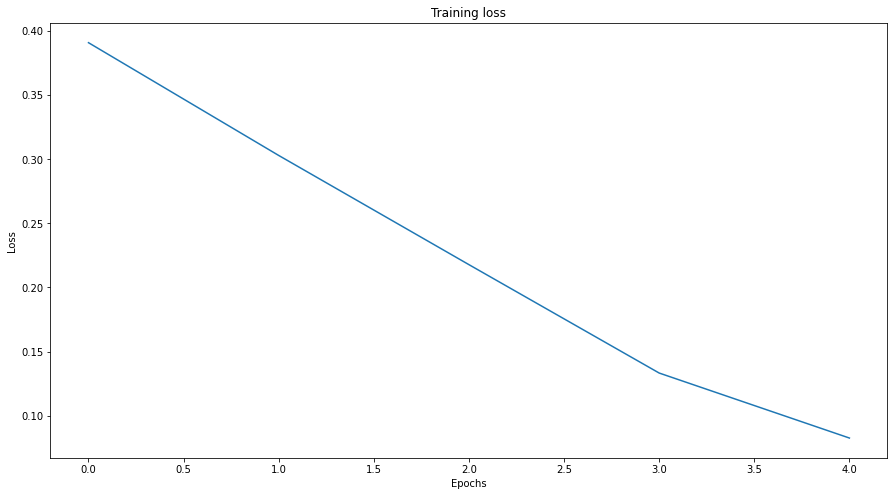

In [ ]:
# plot training epochs performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(train_history_epochs)
plt.show()

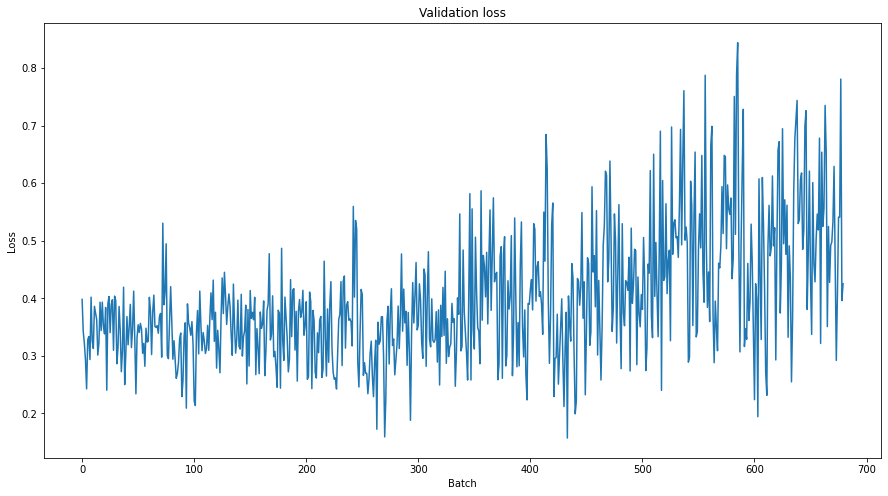

In [ ]:
# plot validation performance
plt.figure(figsize=(15,8))
plt.title("Validation loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(val_history)
plt.show()

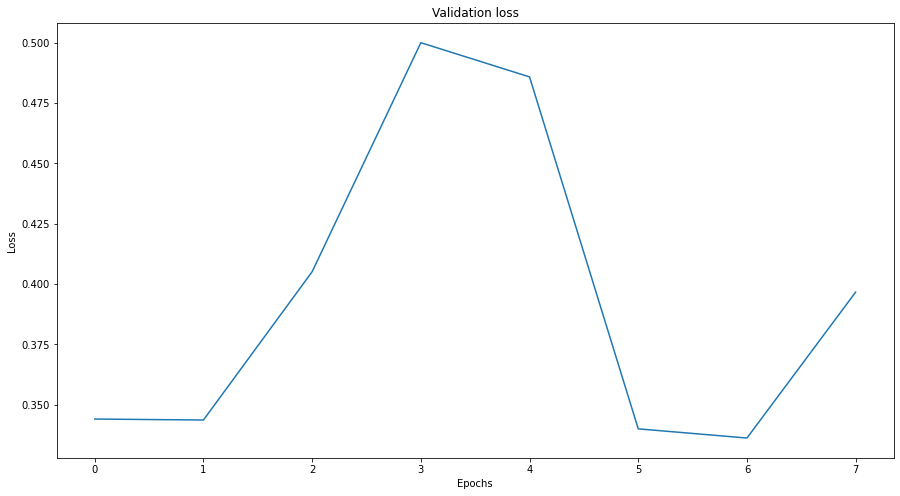

In [ ]:
# plot validation performance
plt.figure(figsize=(15,8))
plt.title("Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(val_history_epochs)
plt.show()

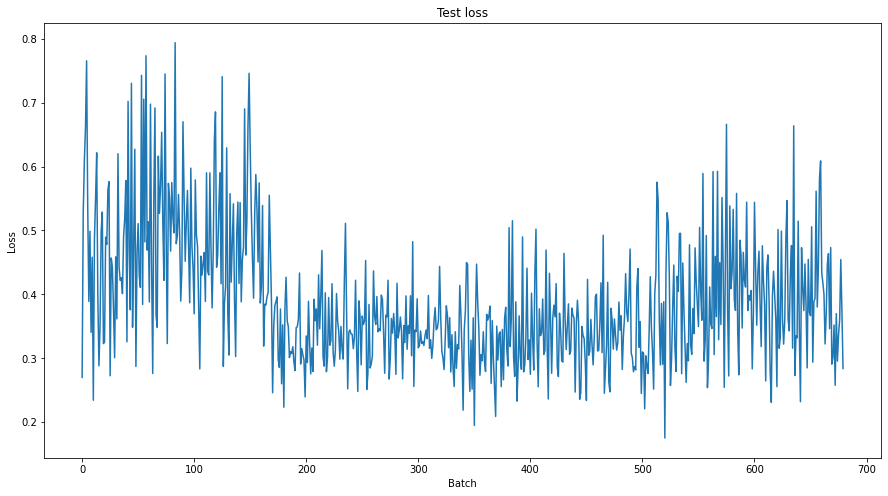

In [ ]:
# plot testing performance
plt.figure(figsize=(15,8))
plt.title("Test loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(test_history)
plt.show()